In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Data Loading

In [ ]:
#colab load
from google.colab import drive
drive.mount('/content/drive')

train_data = pd.read_csv("/content/drive/My Drive/RDS Final Project/kaggle-prudential/code/data/train.csv")
test_cols = pd.read_csv("/content/drive/My Drive/RDS Final Project/kaggle-prudential/code/data/test.csv")
test_preds = pd.read_csv("/content/drive/My Drive/RDS Final Project/kaggle-prudential/code/submissions/submission.csv")
test_w_preds = pd.concat([test_cols, test_preds], axis = 1)

Mounted at /content/drive


In [2]:
#load test data
train_data = pd.read_csv("./data/train.csv")
test_cols = pd.read_csv("./data/test.csv")
test_preds = pd.read_csv("./submissions/submission.csv")
test_w_preds = pd.concat([test_cols, test_preds], axis = 1)

### Data Exploration

In [ ]:
#number of columns:
print(len(test_cols.columns))

127


In [ ]:
#datatype by col
for col in test_cols.columns:
    print(f"{col} -- Type: {type(test_cols[col][0])}")

Id -- Type: <class 'numpy.int64'>
Product_Info_1 -- Type: <class 'numpy.int64'>
Product_Info_2 -- Type: <class 'str'>
Product_Info_3 -- Type: <class 'numpy.int64'>
Product_Info_4 -- Type: <class 'numpy.float64'>
Product_Info_5 -- Type: <class 'numpy.int64'>
Product_Info_6 -- Type: <class 'numpy.int64'>
Product_Info_7 -- Type: <class 'numpy.int64'>
Ins_Age -- Type: <class 'numpy.float64'>
Ht -- Type: <class 'numpy.float64'>
Wt -- Type: <class 'numpy.float64'>
BMI -- Type: <class 'numpy.float64'>
Employment_Info_1 -- Type: <class 'numpy.float64'>
Employment_Info_2 -- Type: <class 'numpy.int64'>
Employment_Info_3 -- Type: <class 'numpy.int64'>
Employment_Info_4 -- Type: <class 'numpy.float64'>
Employment_Info_5 -- Type: <class 'numpy.int64'>
Employment_Info_6 -- Type: <class 'numpy.float64'>
InsuredInfo_1 -- Type: <class 'numpy.int64'>
InsuredInfo_2 -- Type: <class 'numpy.int64'>
InsuredInfo_3 -- Type: <class 'numpy.int64'>
InsuredInfo_4 -- Type: <class 'numpy.int64'>
InsuredInfo_5 -- Typ

In [ ]:
#missing values by column
print("Number of NaNs:", test_cols.isna().sum()[test_cols.isna().sum() != 0])

Number of NaNs: Employment_Info_1          3
Employment_Info_4       2137
Employment_Info_6       3787
Insurance_History_5     8105
Family_Hist_2           9880
Family_Hist_3          11064
Family_Hist_4           6677
Family_Hist_5          13624
Medical_History_1       2972
Medical_History_10     19564
Medical_History_15     14864
Medical_History_24     18585
Medical_History_32     19414
dtype: int64


<ipython-input-6-d0a06d7f51be>:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


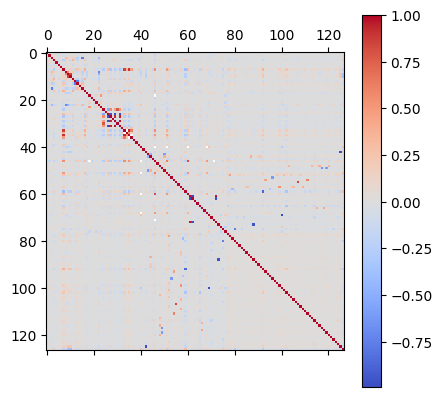

In [ ]:
#correlations
corr_mat = train_data.drop("Product_Info_2", axis = 1).corr()
cax = plt.matshow(corr_mat, cmap = "coolwarm")
plt.colorbar(cax)
plt.tight_layout()
plt.show()

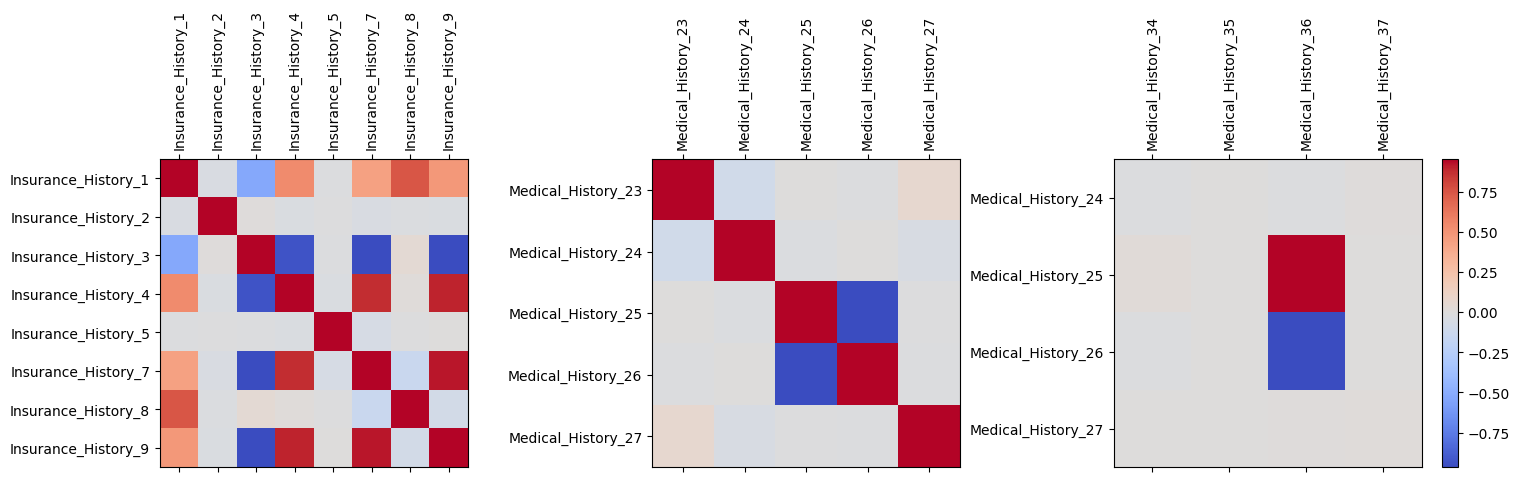

In [ ]:
#examining some of those high correlation areas
corr_mat = train_data.drop("Product_Info_2", axis = 1).corr()
ins_history_subset = train_data.loc[:, "Insurance_History_1":"Insurance_History_9"].corr()
med_history_subset = train_data.iloc[:, 60:65].corr()
med_history_subset_2 = train_data.drop("Product_Info_2", axis = 1).corr().iloc[60:64, 70:74]

matrices = [ins_history_subset, med_history_subset, med_history_subset_2]

fig, axes = plt.subplots(1,3, figsize = (18, 4))
for i, ax in enumerate(axes.flat):
    cax = ax.matshow(matrices[i], cmap = "coolwarm")
    ax.set_xticks(range(len(matrices[i].columns)), matrices[i].columns, rotation=90)
    ax.set_yticks(range(len(matrices[i].columns)), matrices[i].columns, rotation=0)

#setting ticks for this one manually since its an asymmetric slice and requires a different method
axes[2].set_xticks(range(len(med_history_subset_2.columns)), corr_mat.columns[70:74], rotation=90)
axes[2].set_yticks(range(len(med_history_subset_2.columns)), corr_mat.columns[60:64], rotation=0)

fig.colorbar(cax)
plt.show()

Text(0, 0.5, 'Proportion')

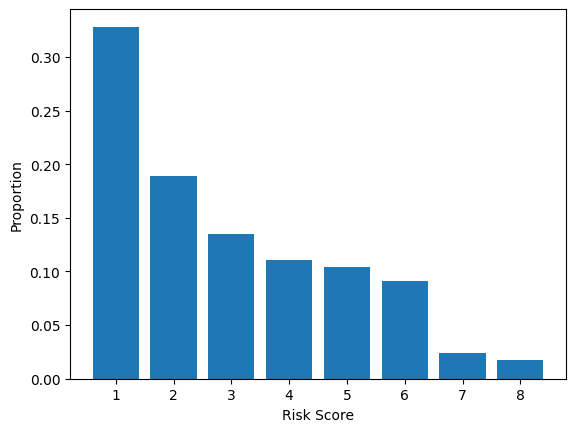

In [ ]:
#distribution of response (train set)

plt.bar(range(1, 8+1), (train_data["Response"].value_counts() / len(train_data)))
plt.xlabel("Risk Score")
plt.ylabel("Proportion")

Text(0, 0.5, 'Count')

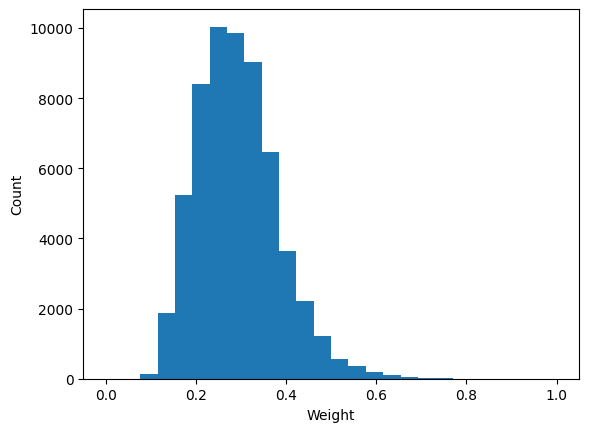

In [ ]:
#dist of weight
plt.hist(train_data["Wt"], bins = 26)
plt.xlabel("Weight")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

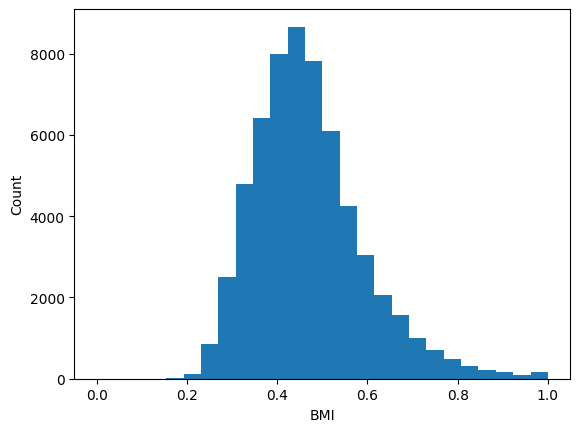

In [ ]:
#dist of bmi
plt.hist(train_data["BMI"], bins = 26)
plt.xlabel("BMI")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

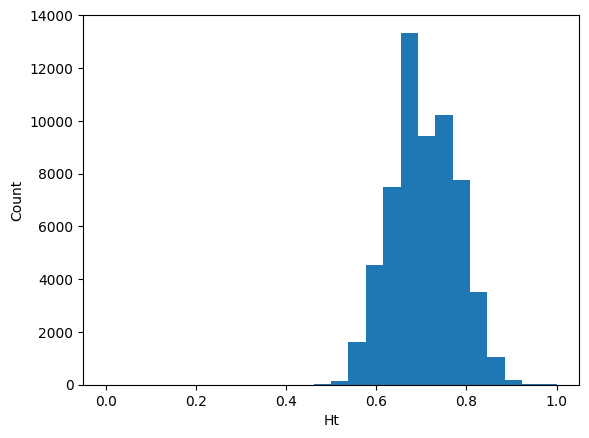

In [ ]:
#dist of height
plt.hist(train_data["Ht"], bins = 26)
plt.xlabel("Ht")
plt.ylabel("Count")

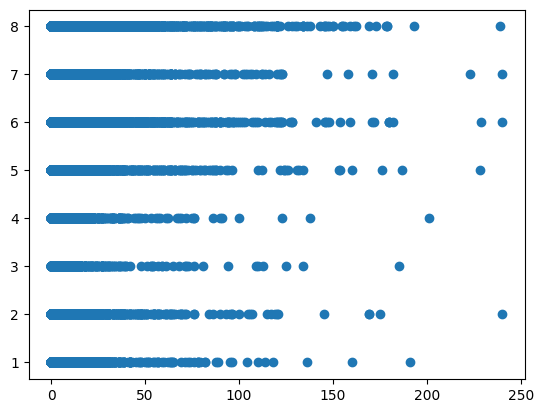

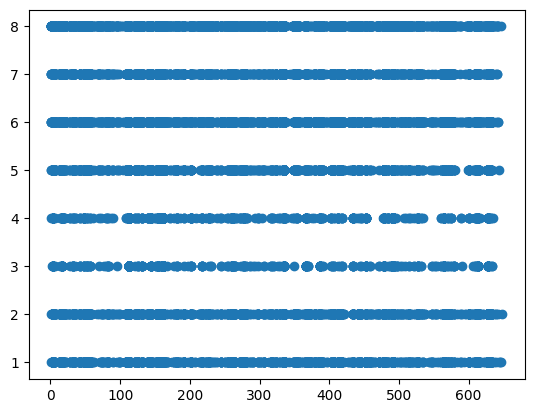

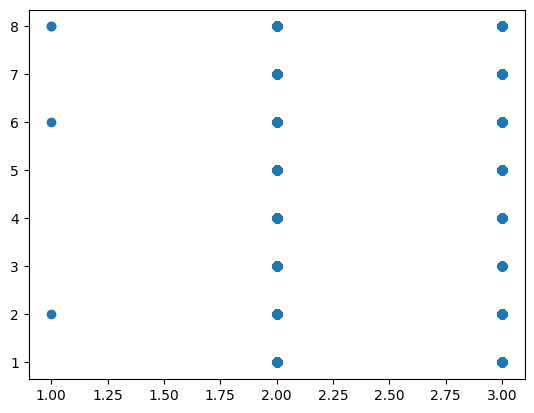

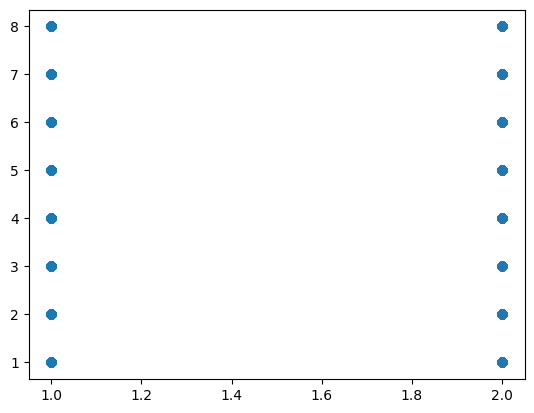

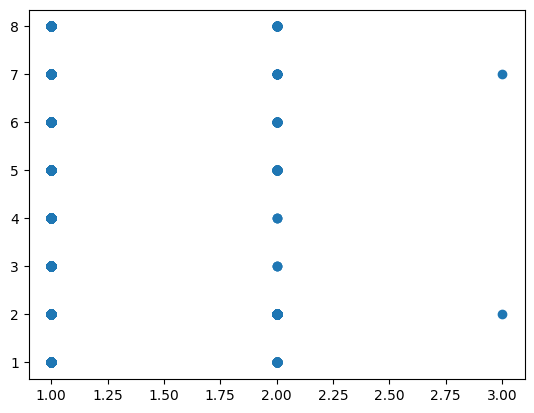

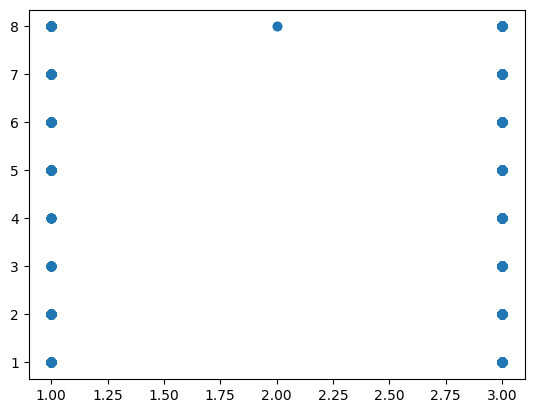

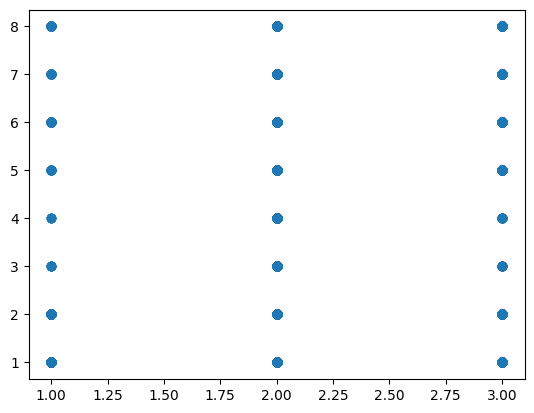

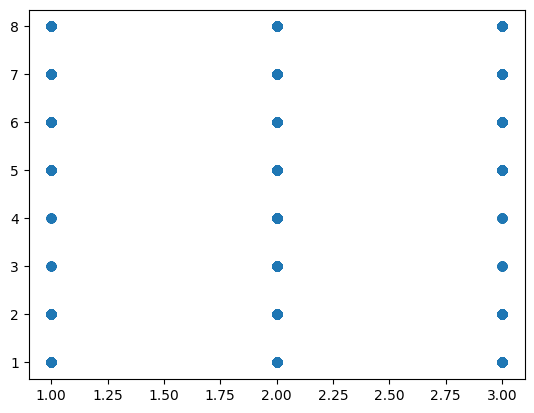

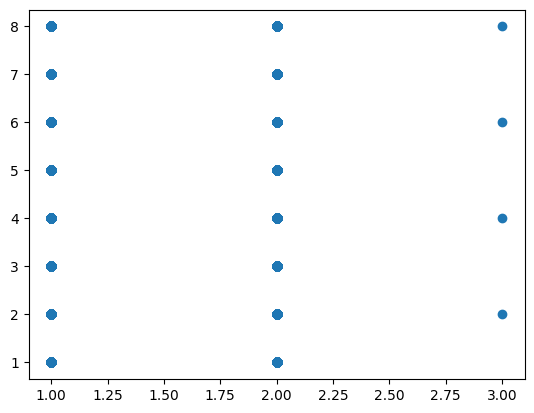

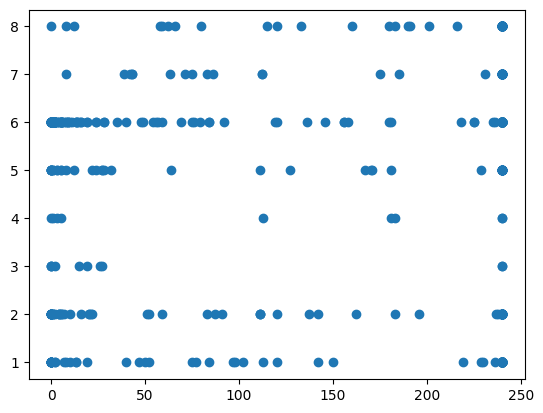

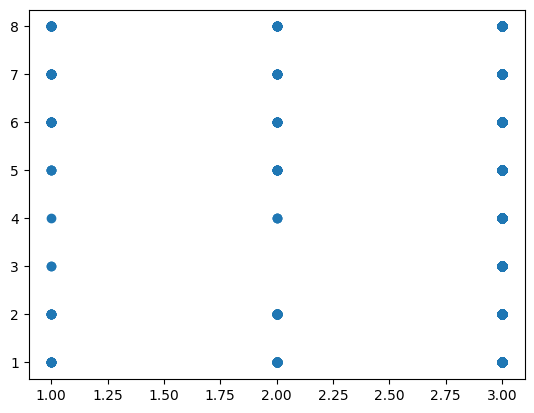

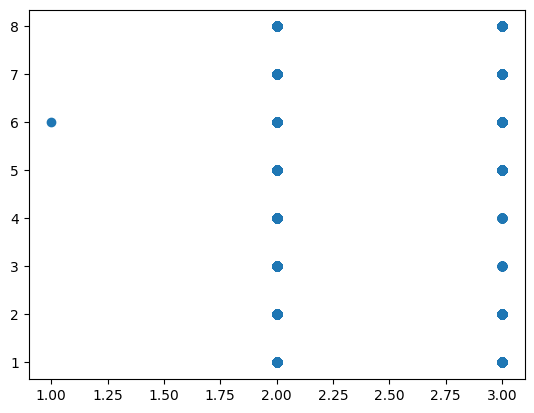

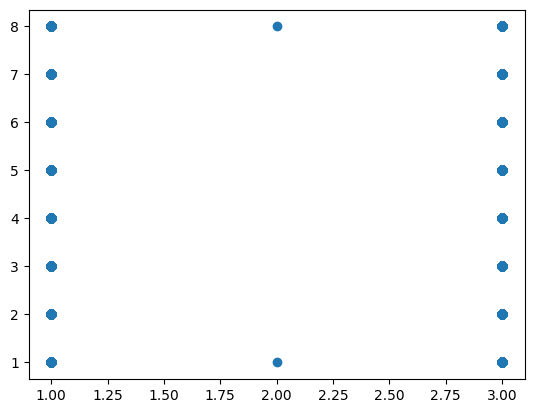

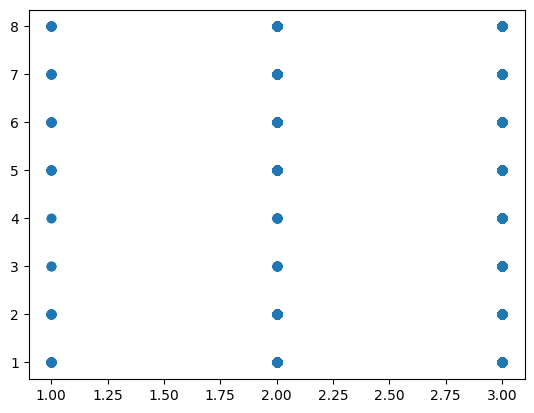

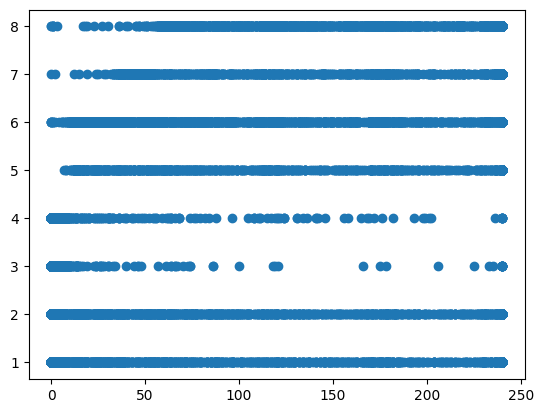

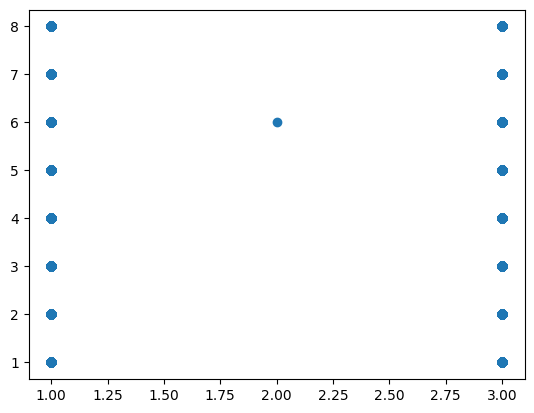

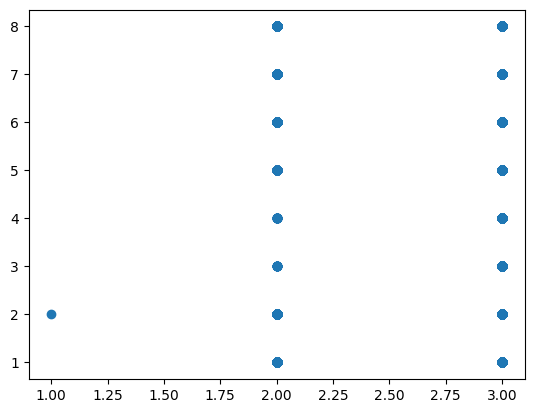

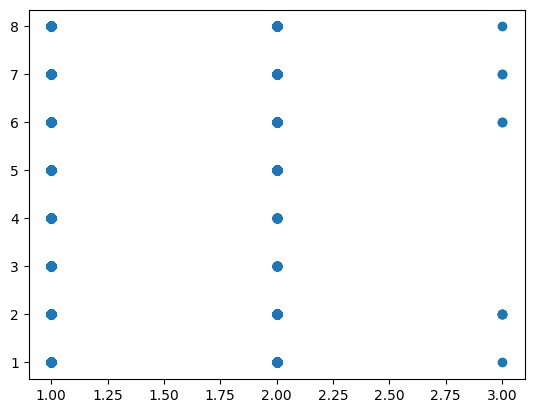

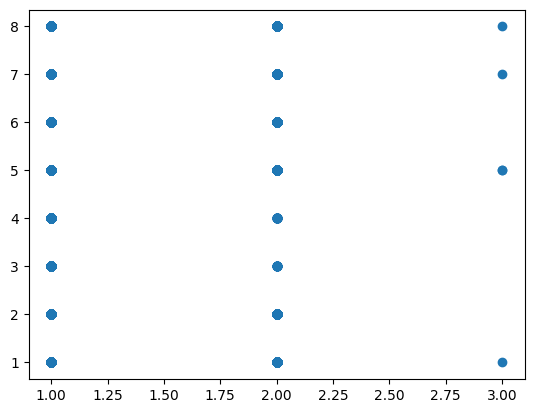

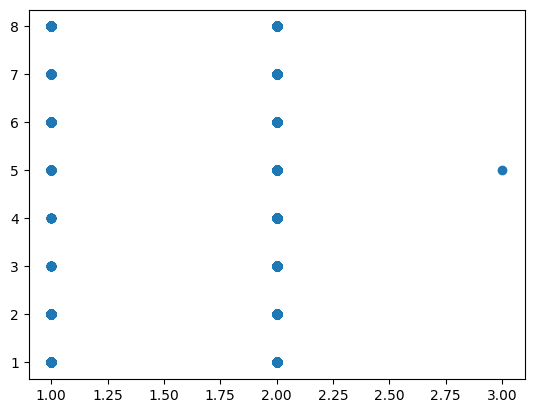

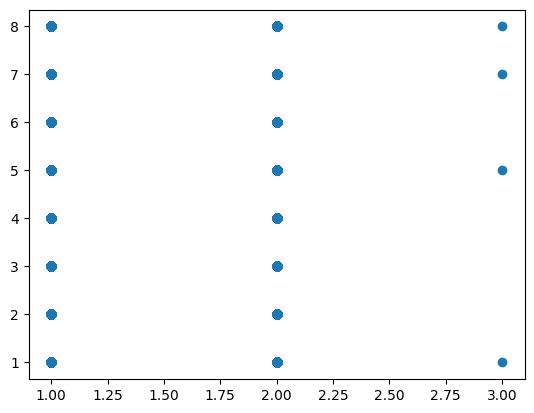

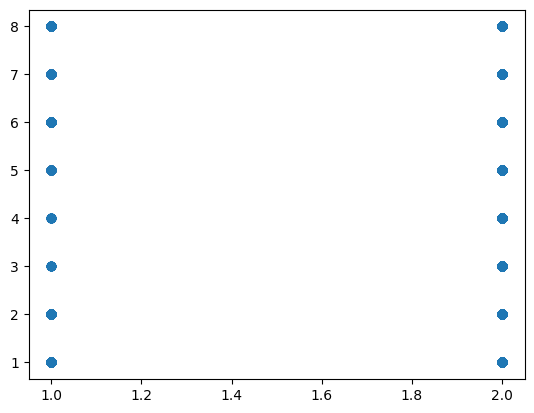

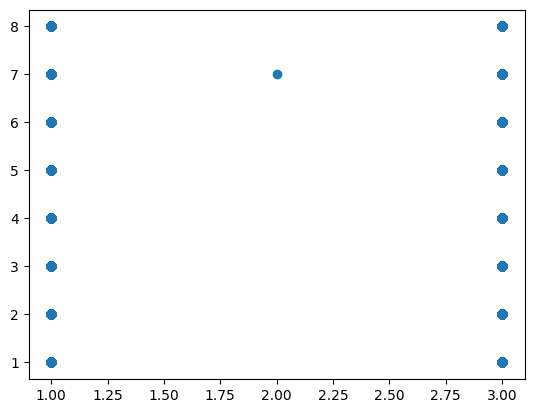

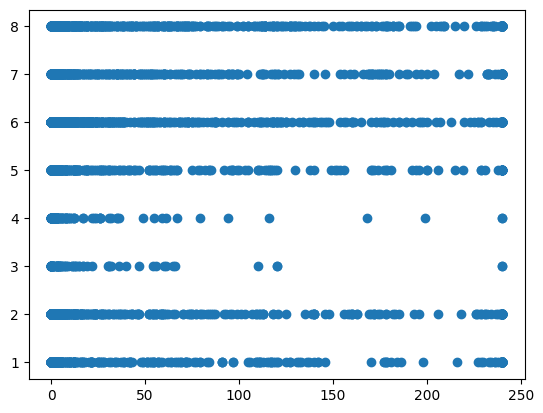

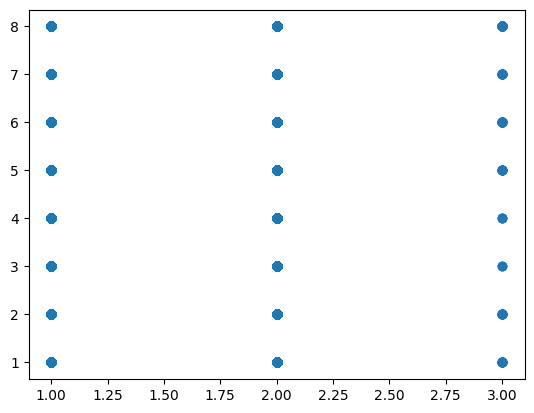

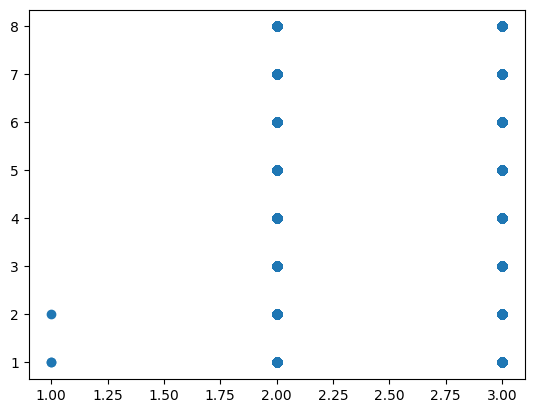

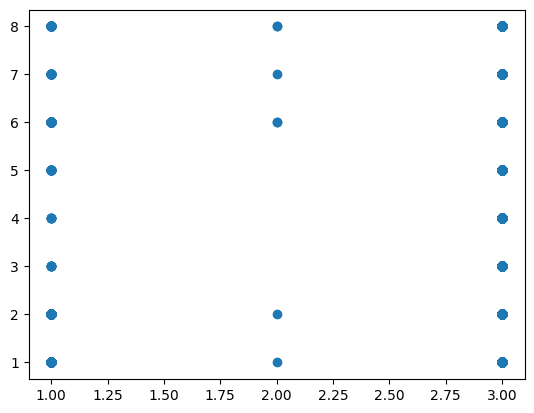

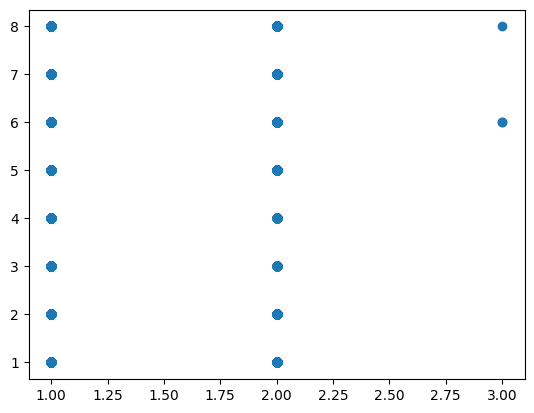

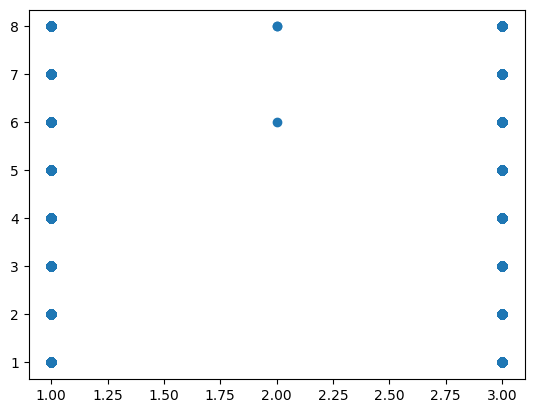

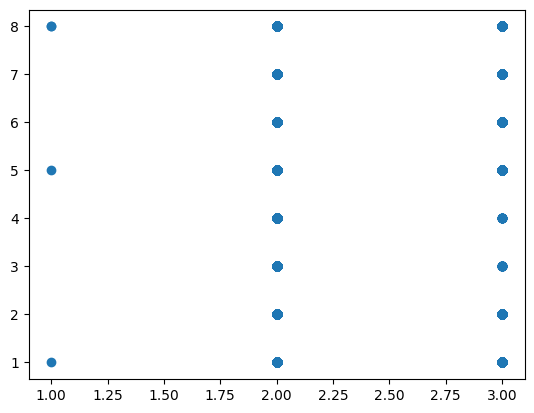

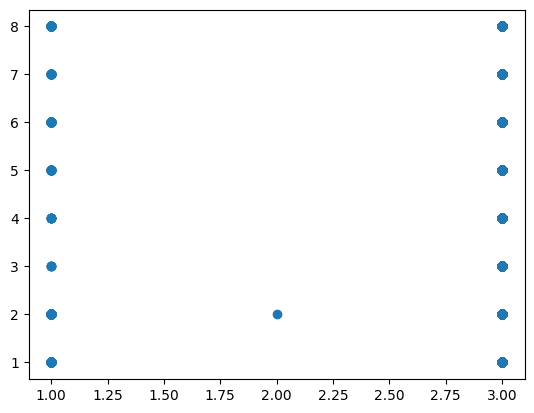

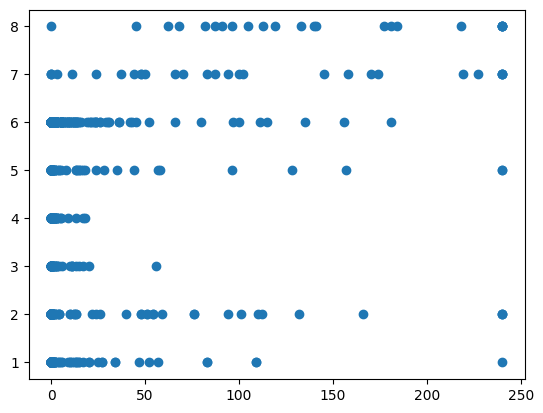

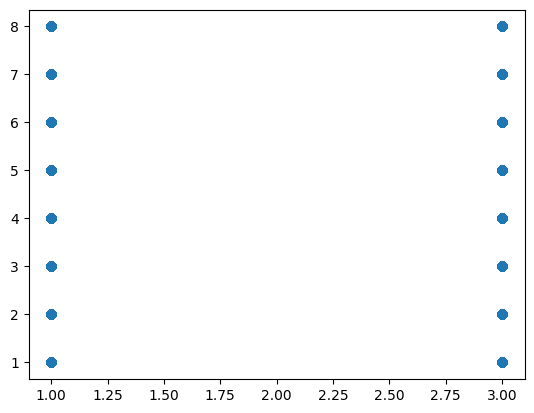

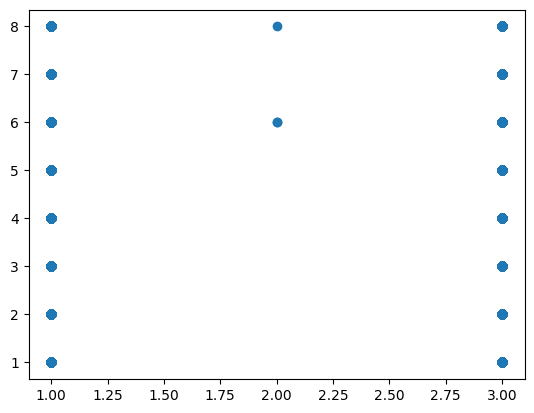

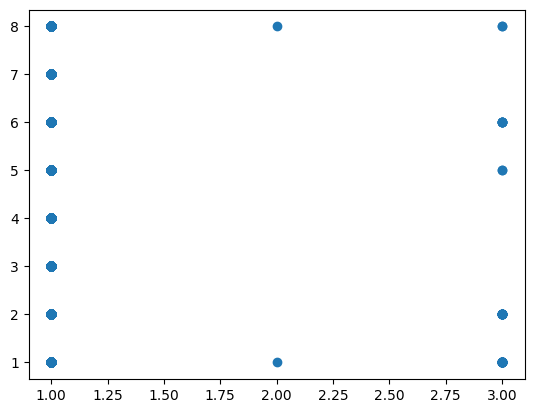

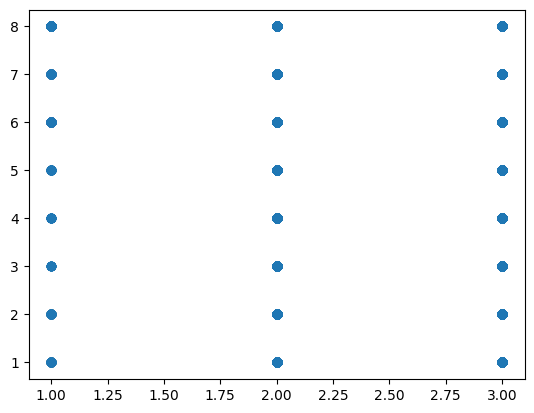

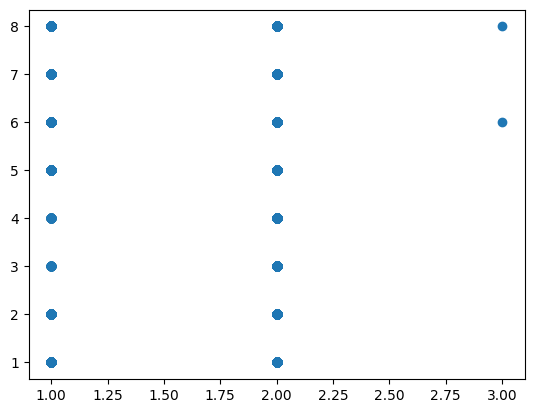

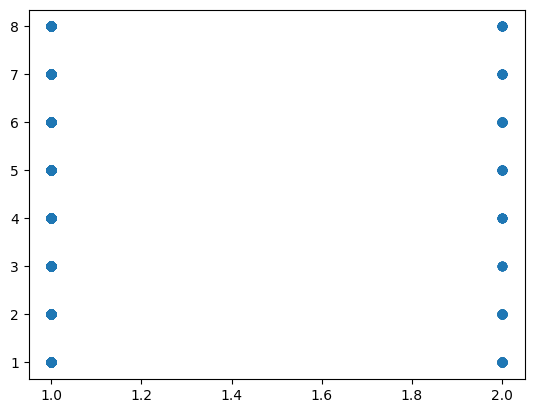

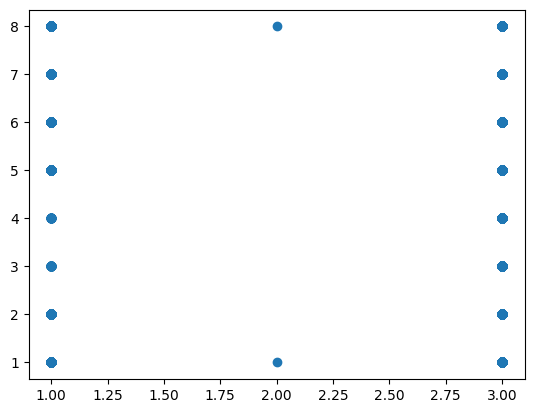

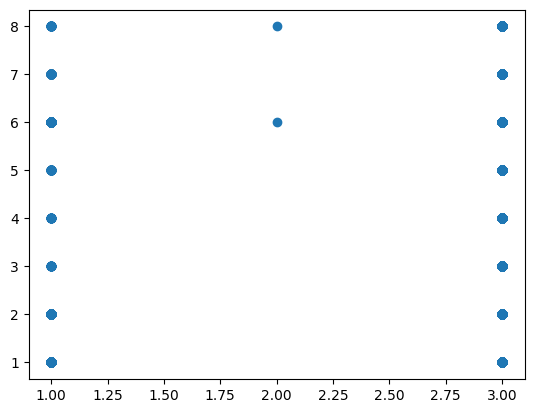

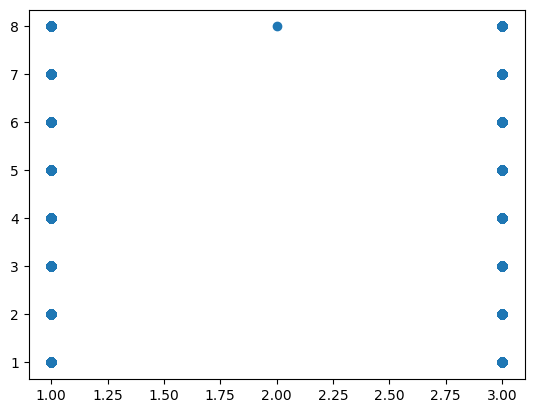

In [ ]:
#some medical history plots
base = "Medical_History_"

for i in range(1, 42):
    plt.scatter(train_data[base + str(i)], train_data["Response"])
    plt.show()

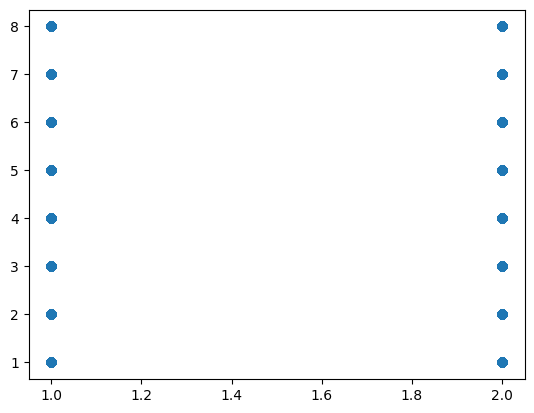

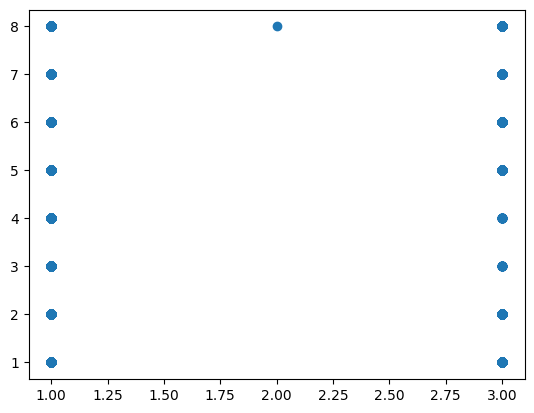

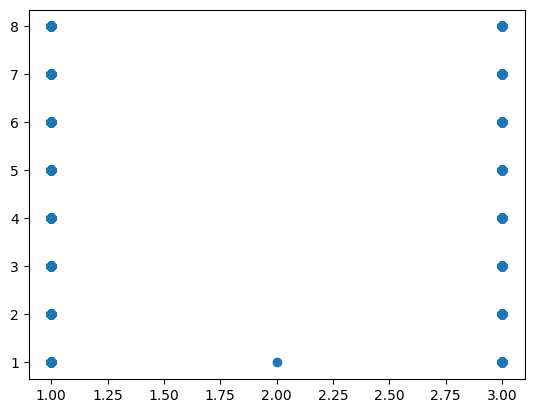

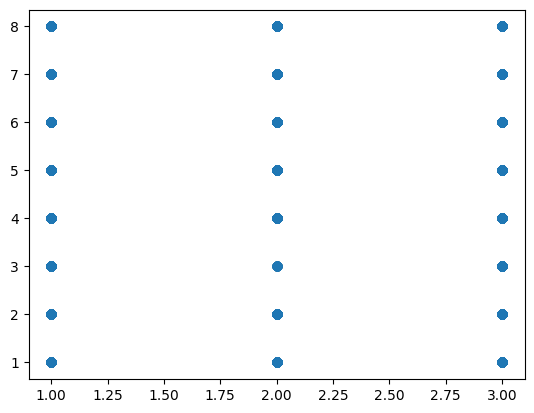

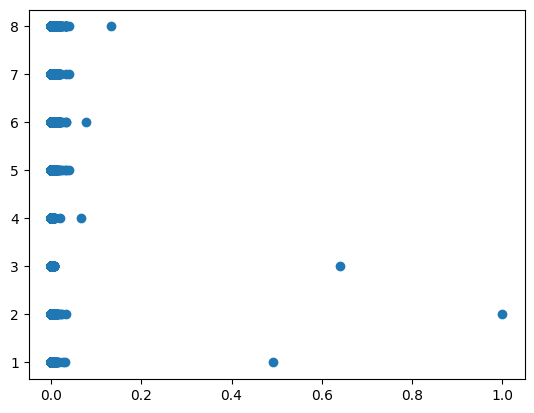

In [ ]:
#some insurance history plots
base = "Insurance_History_"
for i in range(1, 6):
    plt.scatter(train_data[base + str(i)], train_data["Response"])
    plt.show()

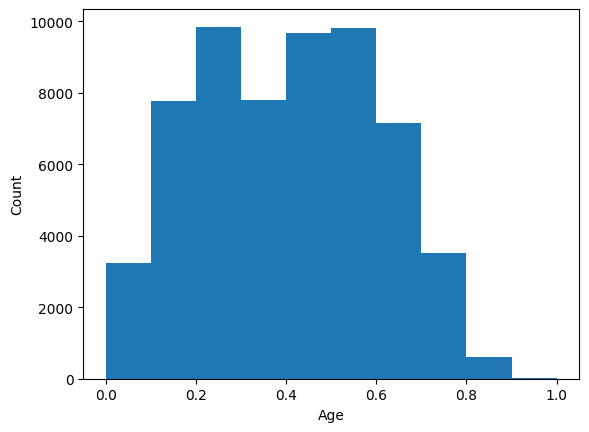

In [ ]:
#age plot
plt.hist(train_data["Ins_Age"])
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

### Fairness Eval

In [ ]:
train_preds = pd.read_csv("/content/drive/My Drive/RDS Final Project/kaggle-prudential/code/features/train_predictons.csv")

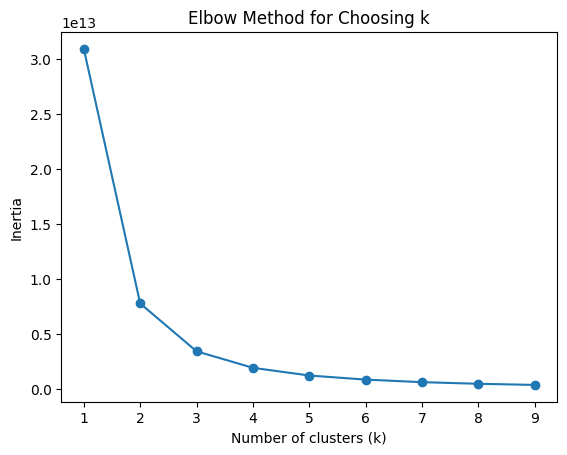

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#train_data = pd.read_csv("/content/drive/My Drive/RDS Final Project/kaggle-prudential/code/data/train.csv")

train_data = pd.read_csv("data/train.csv")


#preprocessing
train_data['Product_Info_2_char'] = train_data.Product_Info_2.str[0]
train_data['Product_Info_2_num'] = train_data.Product_Info_2.str[1]
train_data['Product_Info_2'] = pd.factorize(train_data['Product_Info_2'])[0]
train_data['Product_Info_2_char'] = pd.factorize(train_data['Product_Info_2_char'])[0]
train_data['Product_Info_2_num'] = pd.factorize(train_data['Product_Info_2_num'])[0]
train_data['BMI_Age'] = train_data['BMI'] * train_data['Ins_Age']
med_keyword_columns = train_data.columns[train_data.columns.str.startswith('Medical_Keyword_')]
train_data['Med_Keywords_Count'] = train_data[med_keyword_columns].sum(axis=1)
train_data.apply(lambda x: sum(x.isnull()),1)
train_data['countna'] = train_data.apply(lambda x: sum(x.isnull()),1)
train_data.fillna(-1, inplace=True)
train_data['Response'] = train_data['Response'].astype(int)

inertias = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(train_data.drop("Response", axis = 1, inplace = False))
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 10), inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Choosing k')
plt.show()

In [ ]:
#three looks like the move
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(train_data.drop("Response", axis = 1, inplace = False))
train_data["cluster"] = kmeans.labels_

#add predictions
train_data["predictions"] = train_preds.iloc[:,1]

train_data["binary_risk_real"] = train_data["Response"].apply(lambda x: 1 if x < 4 else 0)
train_data["binary_risk_predictions"] = train_data["predictions"].apply(lambda x: 1 if x < 4 else 0)


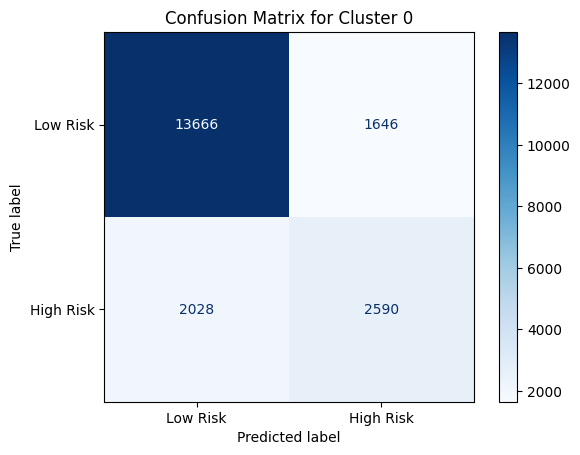

[[13666  1646]
 [ 2028  2590]]


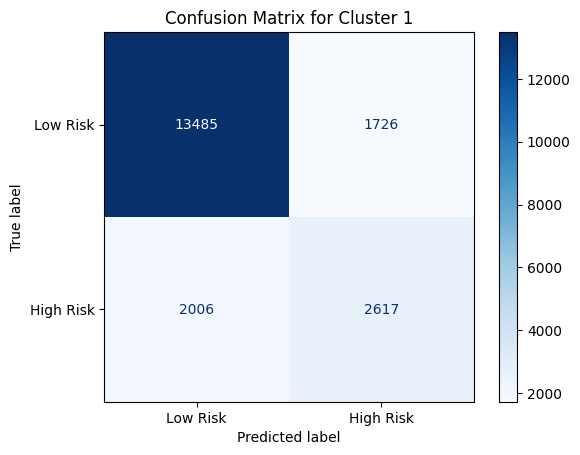

[[13485  1726]
 [ 2006  2617]]


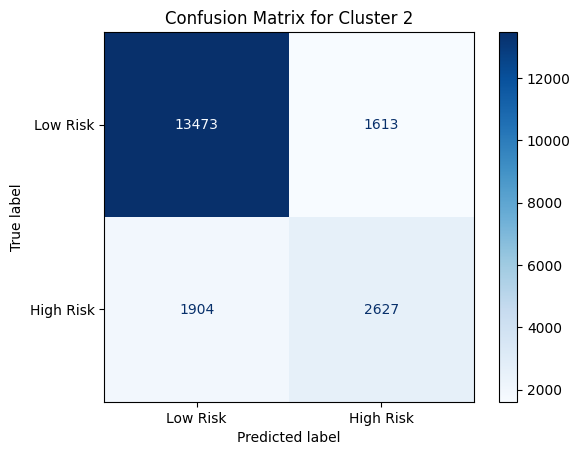

[[13473  1613]
 [ 1904  2627]]


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for cluster in range(num_clusters):
  #group i
  group_0 = train_data[train_data["cluster"] == cluster]
  group_0_real = group_0["binary_risk_real"]
  group_0_preds = group_0["binary_risk_predictions"]

  cm = confusion_matrix(group_0_real, group_0_preds)

  # Display it
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Risk", "High Risk"])
  disp.plot(cmap="Blues")
  plt.title(f"Confusion Matrix for Cluster {cluster}")
  plt.show()

  print(cm)


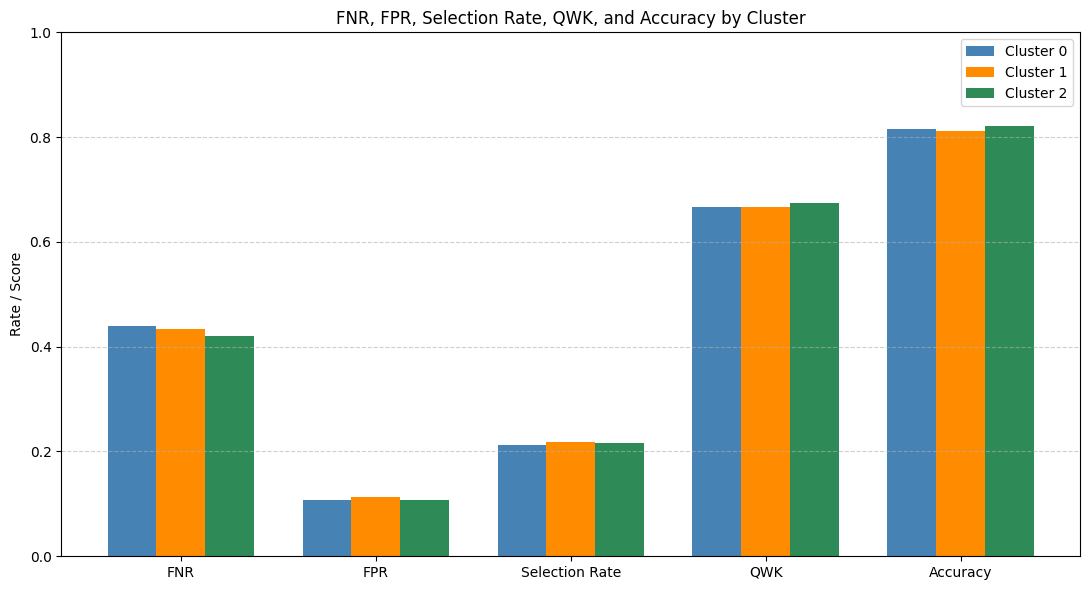

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, cohen_kappa_score

clusters = [0, 1, 2]
fnrs = []
fprs = []
selection_rates = []
qwk_scores = []
accuracies = []

for cluster in clusters:
    group = train_data[train_data["cluster"] == cluster]

    # Binary classification metrics
    y_true = group["binary_risk_real"]
    y_pred = group["binary_risk_predictions"]

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    selection_rate = (tp + fp) / len(group)
    accuracy = (tp + tn) / len(group)

    fnrs.append(fnr)
    fprs.append(fpr)
    selection_rates.append(selection_rate)
    accuracies.append(accuracy)

    # Quadratic Weighted Kappa
    y_true_ord = group["Response"]
    y_pred_ord = group["predictions"].astype(int)

    qwk = cohen_kappa_score(y_true_ord, y_pred_ord, weights="quadratic")
    qwk_scores.append(qwk)

# All metrics
metrics = ['FNR', 'FPR', 'Selection Rate', 'QWK', 'Accuracy']
values = [fnrs, fprs, selection_rates, qwk_scores, accuracies]

x = np.arange(len(metrics))  # [0, 1, 2, 3, 4]
bar_width = 0.25

offsets = [-bar_width, 0, bar_width]
colors = ['steelblue', 'darkorange', 'seagreen']

plt.figure(figsize=(11, 6))

for i, (cluster, offset, color) in enumerate(zip(clusters, offsets, colors)):
    metric_values = [fnrs[i], fprs[i], selection_rates[i], qwk_scores[i], accuracies[i]]
    plt.bar(x + offset, metric_values, width=bar_width, label=f'Cluster {cluster}', color=color)

plt.xticks(x, metrics)
plt.ylabel("Rate / Score")
plt.title("FNR, FPR, Selection Rate, QWK, and Accuracy by Cluster")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

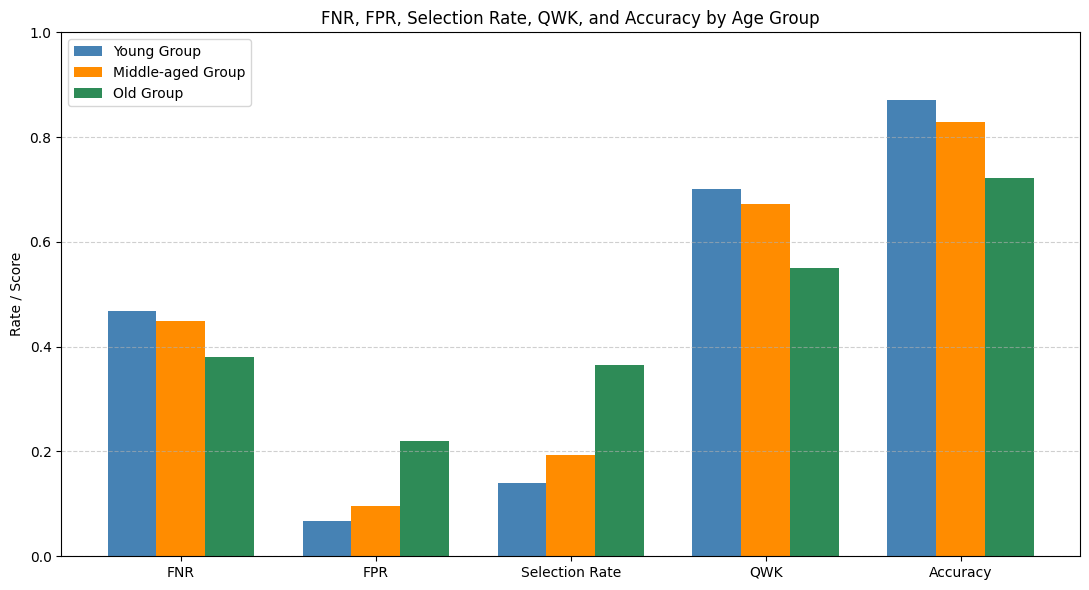

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Bin by age
age_bins = [0, 0.2, 0.6, 1]
age_groups = ['Young', 'Middle-Aged', 'Old']
train_data["group"] = pd.cut(
    train_data["Ins_Age"],
    bins=age_bins,
    labels=age_groups,
    include_lowest=True,
    right=False
)

# Assign predictions and binarized targets
train_data["predictions"] = train_preds.iloc[:, 1]
train_data["binary_risk_real"] = train_data["Response"].apply(lambda x: 1 if x < 4 else 0)
train_data["binary_risk_predictions"] = train_data["predictions"].apply(lambda x: 1 if x < 4 else 0)

# Metric containers
fnrs = []
fprs = []
selection_rates = []
qwk_scores = []
accuracies = []

# Loop through each age group
for group in age_groups:
    group_df = train_data[train_data["group"] == group]

    # Binary classification metrics
    y_true = group_df["binary_risk_real"]
    y_pred = group_df["binary_risk_predictions"]

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    selection_rate = (tp + fp) / len(group_df)
    accuracy = (tp + tn) / len(group_df)

    fnrs.append(fnr)
    fprs.append(fpr)
    selection_rates.append(selection_rate)
    accuracies.append(accuracy)

    # Quadratic Weighted Kappa
    y_true_ord = group_df["Response"]
    y_pred_ord = group_df["predictions"].astype(int)

    qwk = cohen_kappa_score(y_true_ord, y_pred_ord, weights="quadratic")
    qwk_scores.append(qwk)

# Plotting
metrics = ['FNR', 'FPR', 'Selection Rate', 'QWK', 'Accuracy']
values = [fnrs, fprs, selection_rates, qwk_scores, accuracies]

x = np.arange(len(metrics))
bar_width = 0.25
offsets = [-bar_width, 0, bar_width]
colors = ['steelblue', 'darkorange', 'seagreen']

plt.figure(figsize=(11, 6))

for i, (group, offset, color) in enumerate(zip(age_groups, offsets, colors)):
    metric_values = [fnrs[i], fprs[i], selection_rates[i], qwk_scores[i], accuracies[i]]
    plt.bar(x + offset, metric_values, width=bar_width, label=f'{age_groups[i]} Group', color=color)

plt.xticks(x, metrics)
plt.ylabel("Rate / Score")
plt.title("FNR, FPR, Selection Rate, QWK, and Accuracy by Age Group")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

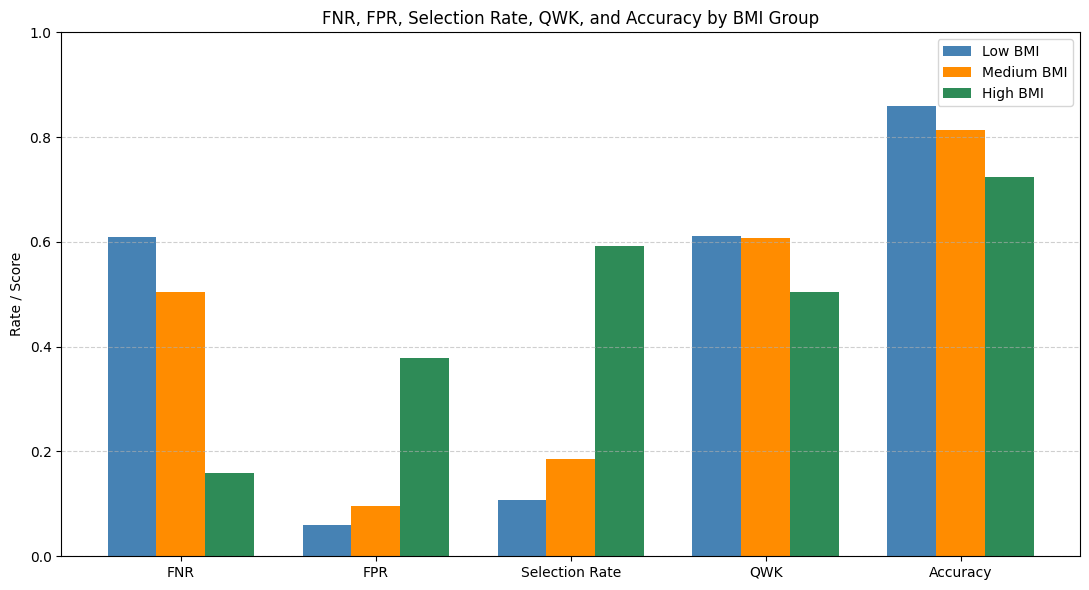

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Define BMI bins and group labels
bmi_bins = [0, 0.4, 0.6, 1]
bmi_groups = ['Low', 'Medium', 'High']

# Bin the BMI values
train_data["group"] = pd.cut(
    train_data["BMI"],
    bins=bmi_bins,
    labels=bmi_groups,
    include_lowest=True,
    right=False
)

# Use model predictions
train_data["predictions"] = train_preds.iloc[:, 1]

# Create binary classification targets
train_data["binary_risk_real"] = train_data["Response"].apply(lambda x: 1 if x < 4 else 0)
train_data["binary_risk_predictions"] = train_data["predictions"].apply(lambda x: 1 if x < 4 else 0)

# Metric containers
fnrs = []
fprs = []
selection_rates = []
qwk_scores = []
accuracies = []

# Loop over each BMI group
for group in bmi_groups:
    group_df = train_data[train_data["group"] == group]

    # Binary classification metrics
    y_true_bin = group_df["binary_risk_real"]
    y_pred_bin = group_df["binary_risk_predictions"]

    tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin).ravel()

    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    selection_rate = (tp + fp) / len(group_df)
    accuracy = (tp + tn) / len(group_df)

    fnrs.append(fnr)
    fprs.append(fpr)
    selection_rates.append(selection_rate)
    accuracies.append(accuracy)

    # Quadratic Weighted Kappa using original ordinal labels
    y_true_ord = group_df["Response"]
    y_pred_ord = group_df["predictions"].astype(int)

    qwk = cohen_kappa_score(y_true_ord, y_pred_ord, weights="quadratic")
    qwk_scores.append(qwk)

# Plotting
metrics = ['FNR', 'FPR', 'Selection Rate', 'QWK', 'Accuracy']
values = [fnrs, fprs, selection_rates, qwk_scores, accuracies]

x = np.arange(len(metrics))
bar_width = 0.25
offsets = [-bar_width, 0, bar_width]
colors = ['steelblue', 'darkorange', 'seagreen']

plt.figure(figsize=(11, 6))

for i, (group, offset, color) in enumerate(zip(bmi_groups, offsets, colors)):
    metric_values = [fnrs[i], fprs[i], selection_rates[i], qwk_scores[i], accuracies[i]]
    plt.bar(x + offset, metric_values, width=bar_width, label=f'{bmi_groups[i]} BMI', color=color)

plt.xticks(x, metrics)
plt.ylabel("Rate / Score")
plt.title("FNR, FPR, Selection Rate, QWK, and Accuracy by BMI Group")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

### SHAP Analysis

In [15]:
import predict
import importlib

importlib.reload(predict)

lr, offsets, lin_reg_train = predict.get_model_and_cutoffs()

Optimization terminated successfully.
         Current function value: -0.668619
         Iterations: 3
         Function evaluations: 429
(19765, 2)
Optimization terminated successfully.
         Current function value: -0.668619
         Iterations: 3
         Function evaluations: 429


In [22]:
coefficients = pd.DataFrame({"name" : lin_reg_train.columns,
                             "coef" : lr.coef_})

coefficients["absolute_impact"] = coefficients["coef"].apply(lambda x : abs(x))

print(coefficients.sort_values(by = "absolute_impact", inplace = False, ascending=False).head(15))

                    name      coef  absolute_impact
141                xgb13 -1.610276         1.610276
137                 xgb9 -1.442160         1.442160
28   InsuranceiHistoryi5  1.368951         1.368951
139                xgb11 -1.296556         1.296556
136                 xgb8  0.886459         0.886459
129                 xgb1 -0.661225         0.661225
131                 xgb3 -0.657380         0.657380
26   InsuranceiHistoryi3 -0.609396         0.609396
134                 xgb6  0.475180         0.475180
138                xgb10 -0.343134         0.343134
140                xgb12 -0.324437         0.324437
69    MedicaliHistoryi35 -0.285752         0.285752
126              BMIiAge  0.234552         0.234552
133                 xgb5 -0.213070         0.213070
113   MedicaliKeywordi38 -0.154192         0.154192


8 of the top 10 (of 142 total) most influential features in the linear regression are output probabilities from the (binary) XGB models. Let's examine those.

#### Making the XGB Models

In [23]:
import pandas as pd 
import xgboost as xgb
import json
from label_decoders import *

config = json.load(open('settings.json'))
train = pd.read_csv(config['train'])
test = pd.read_csv(config['test'])

# combine train and test
all_data = pd.concat([train, test]) #train.append(test)

# create any new variables    
all_data['Product_Info_2_char'] = all_data.Product_Info_2.str[0]
all_data['Product_Info_2_num'] = all_data.Product_Info_2.str[1]
all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]
all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']
med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)
all_data.apply(lambda x: sum(x.isnull()),1)
all_data['countna'] = all_data.apply(lambda x: sum(x.isnull()),1)
all_data.fillna(-1, inplace=True)
all_data['Response'] = all_data['Response'].astype(int)

# split train and test
train_ohd = all_data[all_data['Response']>0].copy()
test_ohd = all_data[all_data['Response']<1].copy()

features=train_ohd.columns.tolist()
features = [x.replace('=','_') for x in features]
features = [x.replace('_','i') for x in features]
train_ohd.columns = features
features_t=test_ohd.columns.tolist()
features_t = [x.replace('=','i') for x in features_t]
features_t = [x.replace('_','i') for x in features_t]
test_ohd.columns = features_t

features.remove("Id")
features.remove("Response")

train_ohd['xgb1'] = [0]*train_ohd.shape[0]
train_ohd['xgb2'] = [0]*train_ohd.shape[0]
train_ohd['xgb3'] = [0]*train_ohd.shape[0]
train_ohd['xgb4'] = [0]*train_ohd.shape[0]
train_ohd['xgb5'] = [0]*train_ohd.shape[0]
train_ohd['xgb6'] = [0]*train_ohd.shape[0]
train_ohd['xgb7'] = [0]*train_ohd.shape[0]
train_ohd['xgb8'] = [0]*train_ohd.shape[0]
train_ohd['xgb9'] = [0]*train_ohd.shape[0]
train_ohd['xgb10'] = [0]*train_ohd.shape[0]
train_ohd['xgb11'] = [0]*train_ohd.shape[0]
train_ohd['xgb12'] = [0]*train_ohd.shape[0]
train_ohd['xgb13'] = [0]*train_ohd.shape[0]


l = train_ohd.shape[0]
ind_list = [(list(range(0,l//10)), [x for x in range(0,l) if x not in list(range(0,l//10))]), 
            (list(range(l//10,l//10*2)), [x for x in range(0,l) if x not in list(range(l//10,l//10*2))]),
            (list(range(l//10*2,l//10*3)), [x for x in range(0,l) if x not in list(range(l//10*2,l//10*3))]),
            (list(range(l//10*3,l//10*4)), [x for x in range(0,l) if x not in list(range(l//10*3,l//10*4))]),
            (list(range(l//10*4,l//10*5)), [x for x in range(0,l) if x not in list(range(l//10*4,l//10*5))]),
            (list(range(l//10*5,l//10*6)), [x for x in range(0,l) if x not in list(range(l//10*5,l//10*6))]),
            (list(range(l//10*6,l//10*7)), [x for x in range(0,l) if x not in list(range(l//10*6,l//10*7))]),
            (list(range(l//10*7,l//10*8)), [x for x in range(0,l) if x not in list(range(l//10*7,l//10*8))]),
            (list(range(l//10*8,l//10*9)), [x for x in range(0,l) if x not in list(range(l//10*8,l//10*9))]),
            (list(range(l//10*9,l)), [x for x in range(0,l) if x not in list(range(l//10*9,l))])]


param = {'max_depth' : 4, 
         'eta' : 0.01, 
         'silent' : 1, 
         'min_child_weight' : 1, 
         'subsample' : 0.5,
         'early_stopping_rounds' : 100,
         'objective'   : 'binary:logistic',
         'eval_metric': 'auc',
         'colsample_bytree':0.3,
         'seed' : 0}

num_round=7000

ld = [labels_decoder1,labels_decoder2,labels_decoder3,labels_decoder4,labels_decoder5,labels_decoder6,labels_decoder7,
      labels_decoder8,labels_decoder9,labels_decoder10,labels_decoder11,labels_decoder12,labels_decoder13]


all_bsts = []

i = 0
for l in ld:
    i = i + 1    
    
    for j in range(10):
        
        X_1, X_2 = ind_list[j][1], ind_list[j][0]
        y_1, y_2 = train_ohd.iloc[X_1]['Response'], train_ohd.iloc[X_2]['Response']
        
        dtrain=xgb.DMatrix(train_ohd.iloc[X_1][features],label=l(y_1),missing=float('nan'))
        dval=xgb.DMatrix(train_ohd.iloc[X_2][features],label=l(y_2),missing=float('nan'))
        
#        watchlist  = [(dtrain,'train'), (dval,'valid')]
        
        bst = xgb.train(param, dtrain, num_round)
        train_ohd['xgb%i' % (i)].iloc[X_2] = bst.predict(dval)

        all_bsts.append(bst)

/Users/jacktinker/miniforge3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:11:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "early_stopping_rounds", "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/var/folders/71/kb4k864551d0xx5bt9s_n_qh0000gn/T/ipykernel_29076/954547874.py:105: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps up

#### Generating training sets

In [28]:
import pandas as pd 
import xgboost as xgb
import json
from label_decoders import *

config = json.load(open('settings.json'))
train = pd.read_csv(config['train'])
test = pd.read_csv(config['test'])

# combine train and test
all_data = pd.concat([train, test]) #train.append(test)

# create any new variables    
all_data['Product_Info_2_char'] = all_data.Product_Info_2.str[0]
all_data['Product_Info_2_num'] = all_data.Product_Info_2.str[1]
all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]
all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']
med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)
all_data.apply(lambda x: sum(x.isnull()),1)
all_data['countna'] = all_data.apply(lambda x: sum(x.isnull()),1)
all_data.fillna(-1, inplace=True)
all_data['Response'] = all_data['Response'].astype(int)

# split train and test
train_ohd = all_data[all_data['Response']>0].copy()
test_ohd = all_data[all_data['Response']<1].copy()

features=train_ohd.columns.tolist()
features = [x.replace('=','_') for x in features]
features = [x.replace('_','i') for x in features]
train_ohd.columns = features
features_t=test_ohd.columns.tolist()
features_t = [x.replace('=','i') for x in features_t]
features_t = [x.replace('_','i') for x in features_t]
test_ohd.columns = features_t

features.remove("Id")
features.remove("Response")

train_ohd['xgb1'] = [0]*train_ohd.shape[0]
train_ohd['xgb2'] = [0]*train_ohd.shape[0]
train_ohd['xgb3'] = [0]*train_ohd.shape[0]
train_ohd['xgb4'] = [0]*train_ohd.shape[0]
train_ohd['xgb5'] = [0]*train_ohd.shape[0]
train_ohd['xgb6'] = [0]*train_ohd.shape[0]
train_ohd['xgb7'] = [0]*train_ohd.shape[0]
train_ohd['xgb8'] = [0]*train_ohd.shape[0]
train_ohd['xgb9'] = [0]*train_ohd.shape[0]
train_ohd['xgb10'] = [0]*train_ohd.shape[0]
train_ohd['xgb11'] = [0]*train_ohd.shape[0]
train_ohd['xgb12'] = [0]*train_ohd.shape[0]
train_ohd['xgb13'] = [0]*train_ohd.shape[0]


l = train_ohd.shape[0]
ind_list = [(list(range(0,l//10)), [x for x in range(0,l) if x not in list(range(0,l//10))]), 
            (list(range(l//10,l//10*2)), [x for x in range(0,l) if x not in list(range(l//10,l//10*2))]),
            (list(range(l//10*2,l//10*3)), [x for x in range(0,l) if x not in list(range(l//10*2,l//10*3))]),
            (list(range(l//10*3,l//10*4)), [x for x in range(0,l) if x not in list(range(l//10*3,l//10*4))]),
            (list(range(l//10*4,l//10*5)), [x for x in range(0,l) if x not in list(range(l//10*4,l//10*5))]),
            (list(range(l//10*5,l//10*6)), [x for x in range(0,l) if x not in list(range(l//10*5,l//10*6))]),
            (list(range(l//10*6,l//10*7)), [x for x in range(0,l) if x not in list(range(l//10*6,l//10*7))]),
            (list(range(l//10*7,l//10*8)), [x for x in range(0,l) if x not in list(range(l//10*7,l//10*8))]),
            (list(range(l//10*8,l//10*9)), [x for x in range(0,l) if x not in list(range(l//10*8,l//10*9))]),
            (list(range(l//10*9,l)), [x for x in range(0,l) if x not in list(range(l//10*9,l))])]


param = {'max_depth' : 4, 
         'eta' : 0.01, 
         'silent' : 1, 
         'min_child_weight' : 1, 
         'subsample' : 0.5,
         'early_stopping_rounds' : 100,
         'objective'   : 'binary:logistic',
         'eval_metric': 'auc',
         'colsample_bytree':0.3,
         'seed' : 0}

num_round=7000

ld = [labels_decoder1,labels_decoder2,labels_decoder3,labels_decoder4,labels_decoder5,labels_decoder6,labels_decoder7,
      labels_decoder8,labels_decoder9,labels_decoder10,labels_decoder11,labels_decoder12,labels_decoder13]


all_trainsets = []

i = 0
for l in ld:
    i = i + 1    
    
    for j in range(10):
        
        X_1, X_2 = ind_list[j][1], ind_list[j][0]
        y_1, y_2 = train_ohd.iloc[X_1]['Response'], train_ohd.iloc[X_2]['Response']
        
        #dtrain=xgb.DMatrix(train_ohd.iloc[X_1][features],label=l(y_1),missing=float('nan'))
        #dval=xgb.DMatrix(train_ohd.iloc[X_2][features],label=l(y_2),missing=float('nan'))
        
#        watchlist  = [(dtrain,'train'), (dval,'valid')]

        all_trainsets.append(train_ohd.iloc[X_1][features])

100%|===================| 999/1000 [01:57<00:00]        

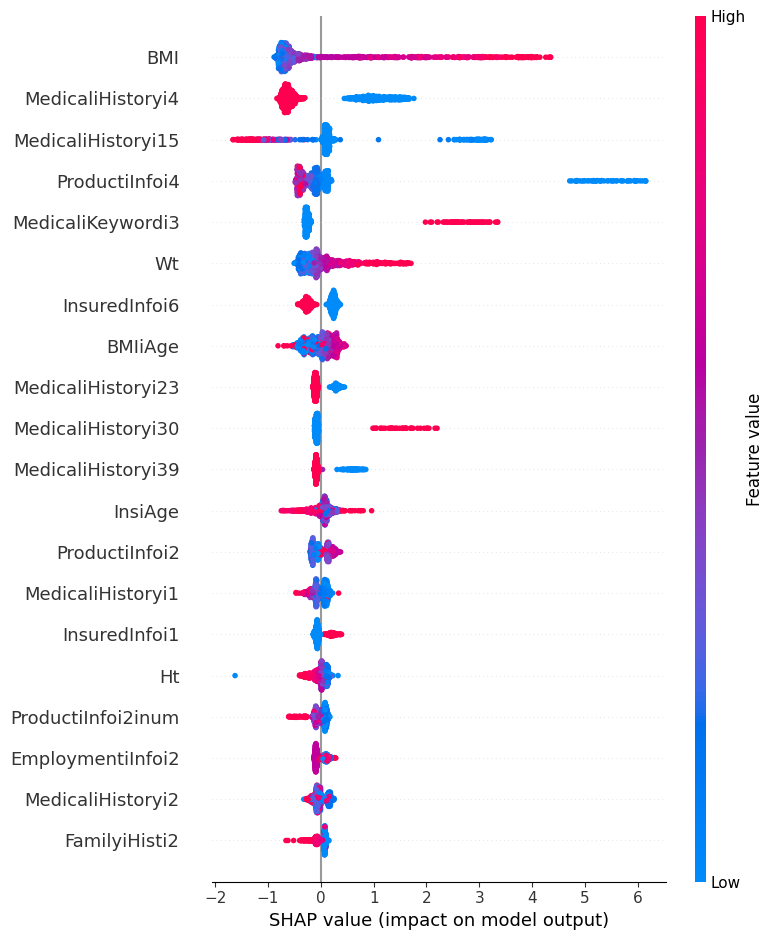

In [29]:
import shap

index = -1

X_sample = all_trainsets[index].sample(n = 1000, random_state = 0)
explainer = shap.TreeExplainer(all_bsts[index], X_sample, approximate = True)
shap_values = explainer(X_sample)

shap.summary_plot(shap_values, X_sample)

100%|===================| 995/1000 [01:54<00:00]        

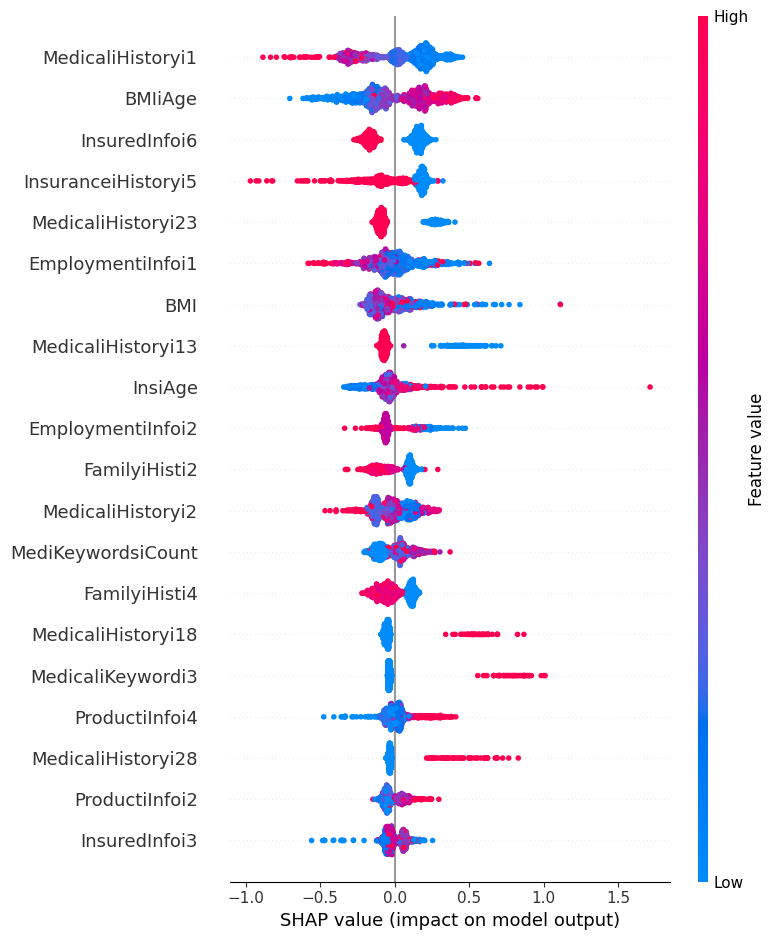

In [31]:
index = 8

X_sample = all_trainsets[index].sample(n = 1000, random_state = 0)
explainer = shap.TreeExplainer(all_bsts[index], X_sample, approximate = True)
shap_values = explainer(X_sample)

shap.summary_plot(shap_values, X_sample)

100%|===================| 998/1000 [01:55<00:00]        

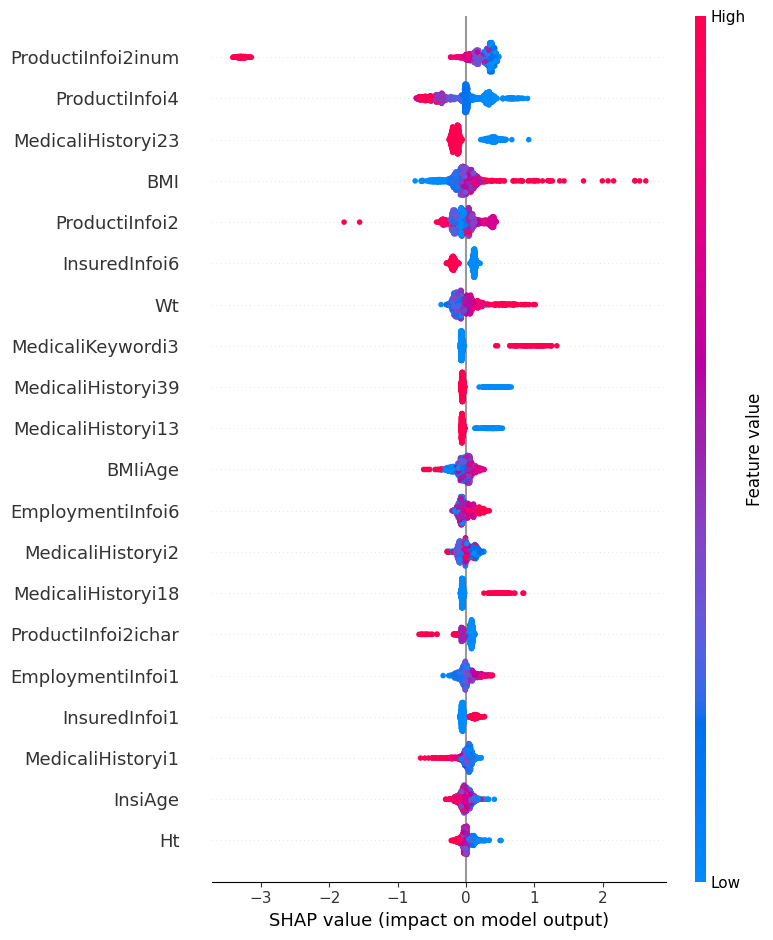

In [32]:
index = 10

X_sample = all_trainsets[index].sample(n = 1000, random_state = 0)
explainer = shap.TreeExplainer(all_bsts[index], X_sample, approximate = True)
shap_values = explainer(X_sample)

shap.summary_plot(shap_values, X_sample)

 99%|===================| 991/1000 [01:54<00:01]        

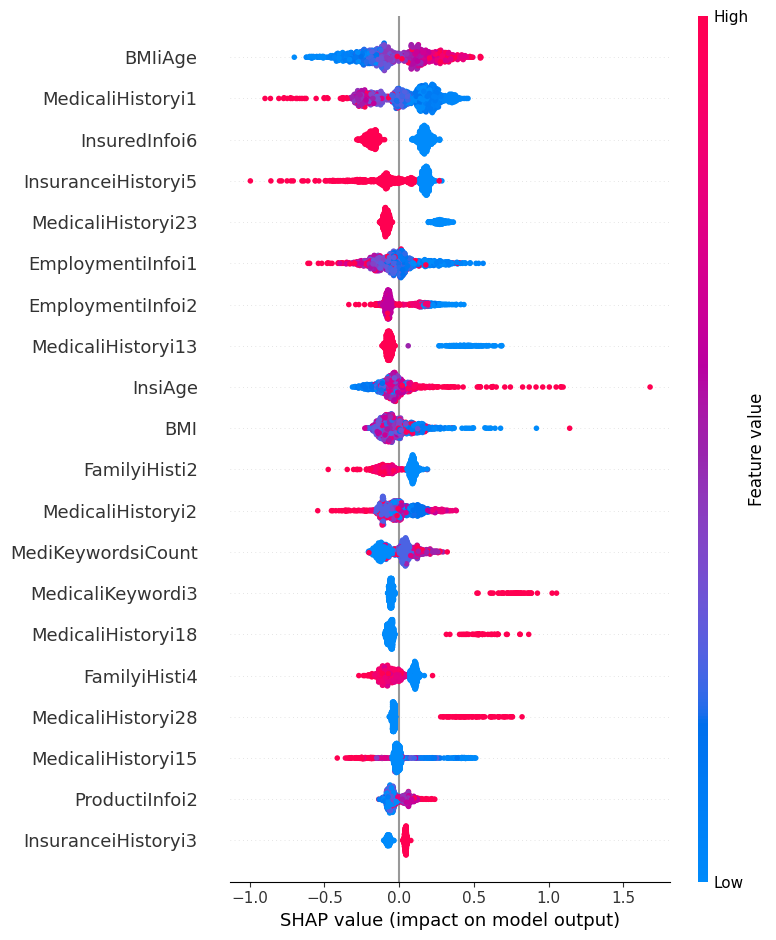

In [33]:
index = 7

X_sample = all_trainsets[index].sample(n = 1000, random_state = 0)
explainer = shap.TreeExplainer(all_bsts[index], X_sample, approximate = True)
shap_values = explainer(X_sample)

shap.summary_plot(shap_values, X_sample)